## - 고양이(y=1), 고양이가 아닌 사진(y=0) 분류하기

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [3]:
# 데이터 로딩
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [8]:
print("Shape:", train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape, classes.shape)

Shape: (209, 64, 64, 3) (1, 209) (50, 64, 64, 3) (1, 50) (2,)


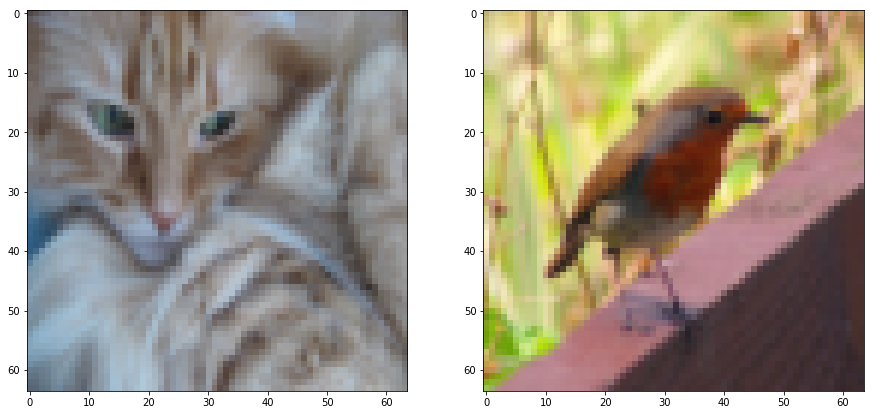

In [118]:
# Example
index = [2, 10]
f, ax = plt.subplots(1, 2, figsize=(15,8))
ax[0].imshow(train_set_x_orig[index[0],:])
ax[1].imshow(train_set_x_orig[index[1],:])

plt.show()

- m_train = Training sample 수
- m_test = Test sample 수
- num_px = Training image의 가로 세로 픽셀 수

In [18]:
m_train= train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("m_train=",m_train, "  m_test= ",m_test, "  num_px=", num_px)

m_train= 209   m_test=  50   num_px= 64


- Training image를 Flatten 시켜주어야 함 --> (n, m_train)의 shape으로

In [24]:
print(train_set_x_orig.shape)
print(test_set_x_orig.shape)

(209, 64, 64, 3)
(50, 64, 64, 3)


In [22]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
train_set_x_flatten.shape

(12288, 209)

In [25]:
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T
test_set_x_flatten.shape

(12288, 50)

train_set_x_orig.resahpe(-1, 209)로 하게되면 Shape은 같으나 원하는 값이  
순서대로 쌓이지 않고 이상한 순서대로 쌓이게됨. 따라서 위처럼 Transpose를 활용

#### 정규화 시켜주기

In [27]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

### Algorithm

In [29]:
# Sigmoid 계산
def sigmoid(z):
    s = 1 / (1+np.exp(-z))
    return s

In [33]:
def initialize_with_zeros(dim):
    w = np.zeros([dim,1])
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w, b

### Forward & Backward propagation

In [58]:
def propagate(w, b, X, Y):
    z = np.dot(w.T, X) + b
    A = sigmoid(z)
    
    m = X.shape[1]
    
    cost = np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) / -m
    
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m
    
    assert(w.shape == dw.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [59]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### Optimization

In [63]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
    
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print('Cost of iter %i: %f' % (i, cost))
            
    params = {"w":w, 
              "b":b}
    grads = {"dw":w,
             "db":b}
    
    return params, grads, costs

In [64]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009,
                               print_cost = False)

In [65]:
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.19033591]
 [0.12259159]]
db = 1.9253598300845747


### Predict

In [70]:
sigmoid(np.dot(w.T, X) + b)[0]

array([0.99987661, 0.99999386, 0.00449627])

In [72]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
            
    return Y_prediction

In [73]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


### 최종 Model

In [79]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000,
         learning_rate = 0.5, print_cost=False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations=num_iterations,
                                   learning_rate=learning_rate)
    
    w = params["w"]
    b = params["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    

In [80]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000,
         learning_rate=0.005, print_cost=True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


### Cost 함수 graph

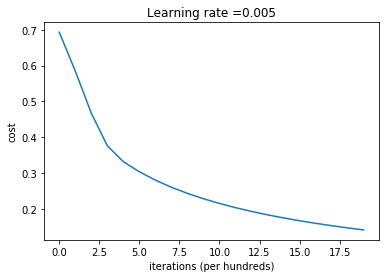

In [82]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### Learning Rate 바꿔보기

In [87]:
learning_rates = [0.01, 0.001, 0.005, 0.009, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.005
train accuracy: 97.60765550239235 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.009
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



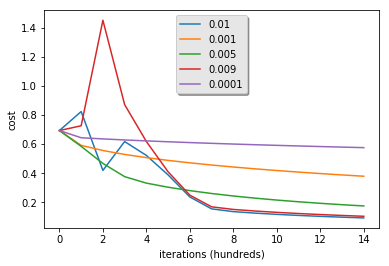

In [89]:
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()